# Diffusion Models for Medical Imaging

This notebook applies diffusion models to **realistic medical images**, demonstrating practical applications of the SDE framework.

**Use case**: Generate synthetic chest X-rays for data augmentation and medical AI training.

**Learning objectives:**
1. Apply U-Net architecture to real medical images
2. Handle grayscale medical imaging data preprocessing
3. Train diffusion models on 128×128 X-ray images
4. Generate synthetic medical images
5. Evaluate with domain-specific metrics

**Dataset**: Chest X-ray images (downsampled to 128×128 for computational efficiency)

**Prerequisites**: `02_sde_formulation.ipynb`

---

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Import genailab modules (no sys.path manipulation needed!)
from genailab.diffusion import (
    VPSDE,
    UNet2D,
    train_score_network,
    sample_reverse_sde,
    sample_probability_flow_ode
)
from genailab import get_config, get_checkpoint_dir, get_device

# Configuration
config = get_config()
device = get_device()
checkpoint_dir = get_checkpoint_dir("diffusion/medical_imaging")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

# Random seeds
np.random.seed(42)
torch.manual_seed(42)

print(f'Using device: {device}')
print(f'Project root: {config.project_root}')
print(f'Checkpoints will be saved to: {checkpoint_dir}')

Using device: mps
Project root: /Users/pleiadian53/work/genai-lab
Checkpoints will be saved to: /Users/pleiadian53/work/genai-lab/checkpoints/diffusion/medical_imaging


## 1. Configuration & Model Presets

Choose a model size based on your hardware:

| Preset | Parameters | VRAM | Image Size | Epochs | Hardware |
|--------|------------|------|------------|--------|----------|
| **tiny** | ~1M | <2GB | 64×64 | 100 | M1 Mac, CPU |
| **small** | ~5M | ~4GB | 64×64 | 500 | T4, RTX 3060 |
| **medium** | ~20M | ~8GB | 128×128 | 2000 | RTX 3080, A10 |
| **large** | ~50M | ~16GB | 128×128 | 5000 | A40, A100 |

**For this demo**: We'll use the **tiny** preset for quick testing. Change to **medium** or **large** for better quality.

In [ ]:
# ============================================================================
# Model Preset Configuration
# ============================================================================

# Choose preset: 'tiny', 'small', 'medium', or 'large'
PRESET = 'tiny'  # Change this to 'medium' or 'large' for better quality

# Preset configurations
PRESETS = {
    "tiny": {
        "base_channels": 16,
        "channel_multipliers": (1, 2, 4),
        "num_res_blocks": 1,
        "time_emb_dim": 64,
        "img_size": 64,
        "batch_size": 32,
        "epochs": 100,
        "n_samples": 1000,
        "description": "~1M params - Quick logic verification (M1 Mac friendly)",
    },
    "small": {
        "base_channels": 32,
        "channel_multipliers": (1, 2, 4),
        "num_res_blocks": 1,
        "time_emb_dim": 128,
        "img_size": 64,
        "batch_size": 32,
        "epochs": 500,
        "n_samples": 2000,
        "description": "~5M params - Local testing with reasonable quality",
    },
    "medium": {
        "base_channels": 48,
        "channel_multipliers": (1, 2, 4, 8),
        "num_res_blocks": 2,
        "time_emb_dim": 192,
        "img_size": 128,
        "batch_size": 16,
        "epochs": 2000,
        "n_samples": 2000,
        "description": "~20M params - Good quality, needs decent GPU",
    },
    "large": {
        "base_channels": 64,
        "channel_multipliers": (1, 2, 4, 8),
        "num_res_blocks": 2,
        "time_emb_dim": 256,
        "img_size": 128,
        "batch_size": 32,
        "epochs": 5000,
        "n_samples": 2000,
        "description": "~50M params - Production quality (A40/A100 recommended)",
    },
}

# Get selected preset
config_preset = PRESETS[PRESET]

print(f"Selected preset: {PRESET}")
print(f"Description: {config_preset['description']}")
print(f"\nConfiguration:")
print(f"  Image size: {config_preset['img_size']}×{config_preset['img_size']}")
print(f"  Base channels: {config_preset['base_channels']}")
print(f"  Channel multipliers: {config_preset['channel_multipliers']}")
print(f"  Residual blocks: {config_preset['num_res_blocks']}")
print(f"  Time embedding dim: {config_preset['time_emb_dim']}")
print(f"  Batch size: {config_preset['batch_size']}")
print(f"  Training epochs: {config_preset['epochs']}")
print(f"  Dataset samples: {config_preset['n_samples']}")

# ============================================================================
# Dataset Preparation
# ============================================================================

# Import the improved SyntheticXRayDataset from genailab
from genailab.diffusion import SyntheticXRayDataset

# Create dataset with diverse synthetic X-rays
dataset = SyntheticXRayDataset(
    n_samples=config_preset['n_samples'], 
    img_size=config_preset['img_size'], 
    seed=42
)
print(f"\nDataset: {len(dataset)} images, shape: {dataset[0].shape}")

# Create dataloader
dataloader = DataLoader(
    dataset, 
    batch_size=config_preset['batch_size'], 
    shuffle=True, 
    num_workers=0
)
print(f"Batches per epoch: {len(dataloader)}")

Dataset: 2000 images, shape: torch.Size([1, 128, 128])
Batches per epoch: 63


### Visualize Sample Images

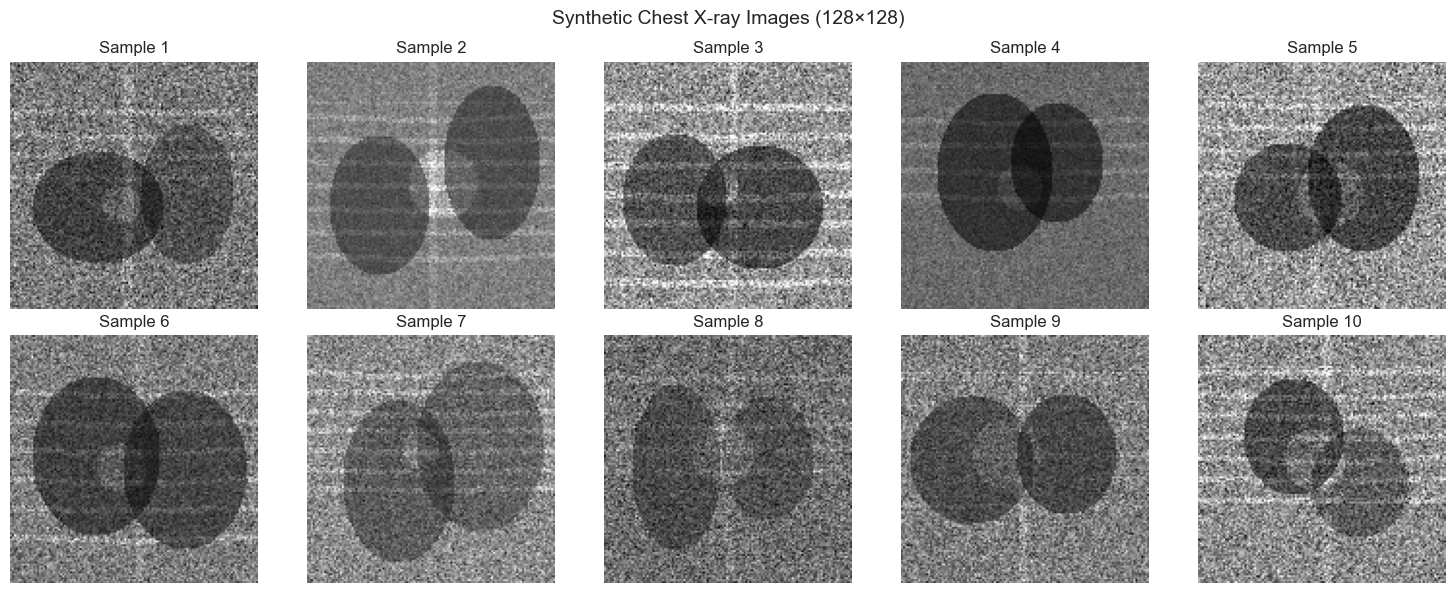

Note: These are synthetic images for demonstration.
Replace with real medical images for production use.


In [3]:
# Visualize samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    img = dataset[i].squeeze().numpy()
    # Denormalize from [-1, 1] to [0, 1]
    img = (img + 1) / 2
    axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')
    axes[i].set_title(f'Sample {i+1}')

plt.suptitle('Synthetic Chest X-ray Images (128×128)', fontsize=14)
plt.tight_layout()
plt.show()

print("Note: These are synthetic images for demonstration.")
print("Replace with real medical images for production use.")

## 2. Model Architecture: U-Net for Medical Images

We use the **UNet2D** architecture specifically designed for medical imaging:
- Encoder-decoder with skip connections
- Multi-scale feature extraction
- GroupNorm (works well with small batches)
- Time conditioning at each resolution

In [ ]:
# Initialize U-Net model with preset configuration
model = UNet2D(
    in_channels=1,              # Grayscale X-rays
    out_channels=1,
    base_channels=config_preset['base_channels'],
    channel_multipliers=config_preset['channel_multipliers'],
    num_res_blocks=config_preset['num_res_blocks'],
    time_emb_dim=config_preset['time_emb_dim'],
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")

# Test forward pass
x_test = torch.randn(4, 1, config_preset['img_size'], config_preset['img_size']).to(device)
t_test = torch.rand(4).to(device)
out_test = model(x_test, t_test)
print(f"Input shape: {x_test.shape}")
print(f"Output shape: {out_test.shape}")
print("✓ Model initialized successfully")

Model parameters: 50,544,513
Input shape: torch.Size([4, 1, 128, 128])
Output shape: torch.Size([4, 1, 128, 128])
✓ Model initialized successfully


## 3. Training Setup

We'll use:
- **VP-SDE** with cosine schedule (better for images)
- **Denoising score matching** loss
- **Adam optimizer** with learning rate 2e-4
- **Gradient clipping** for stability

Using cosine noise schedule


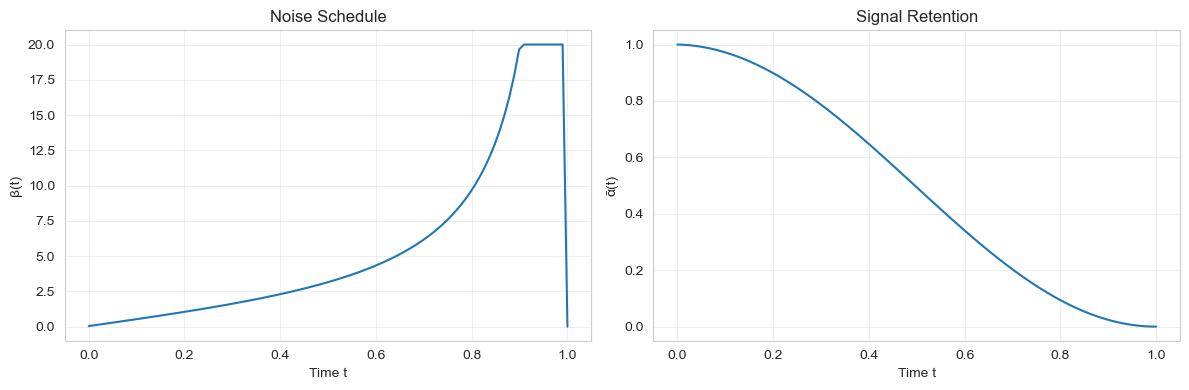

In [13]:
# Initialize SDE with cosine schedule (recommended for images)
sde = VPSDE(schedule='cosine', T=1.0)
print(f"Using {sde.schedule_name} noise schedule")

# Visualize the noise schedule
t_vals = np.linspace(0, 1, 100)
beta_vals = [sde.beta(t) for t in t_vals]
alpha_bar_vals = [sde.schedule.alpha_bar(t) for t in t_vals]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(t_vals, beta_vals)
axes[0].set_xlabel('Time t')
axes[0].set_ylabel('β(t)')
axes[0].set_title('Noise Schedule')
axes[0].grid(True, alpha=0.3)

axes[1].plot(t_vals, alpha_bar_vals)
axes[1].set_xlabel('Time t')
axes[1].set_ylabel('ᾱ(t)')
axes[1].set_title('Signal Retention')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visualize Forward Diffusion Process

Let's see how the SDE corrupts a real X-ray image over time.

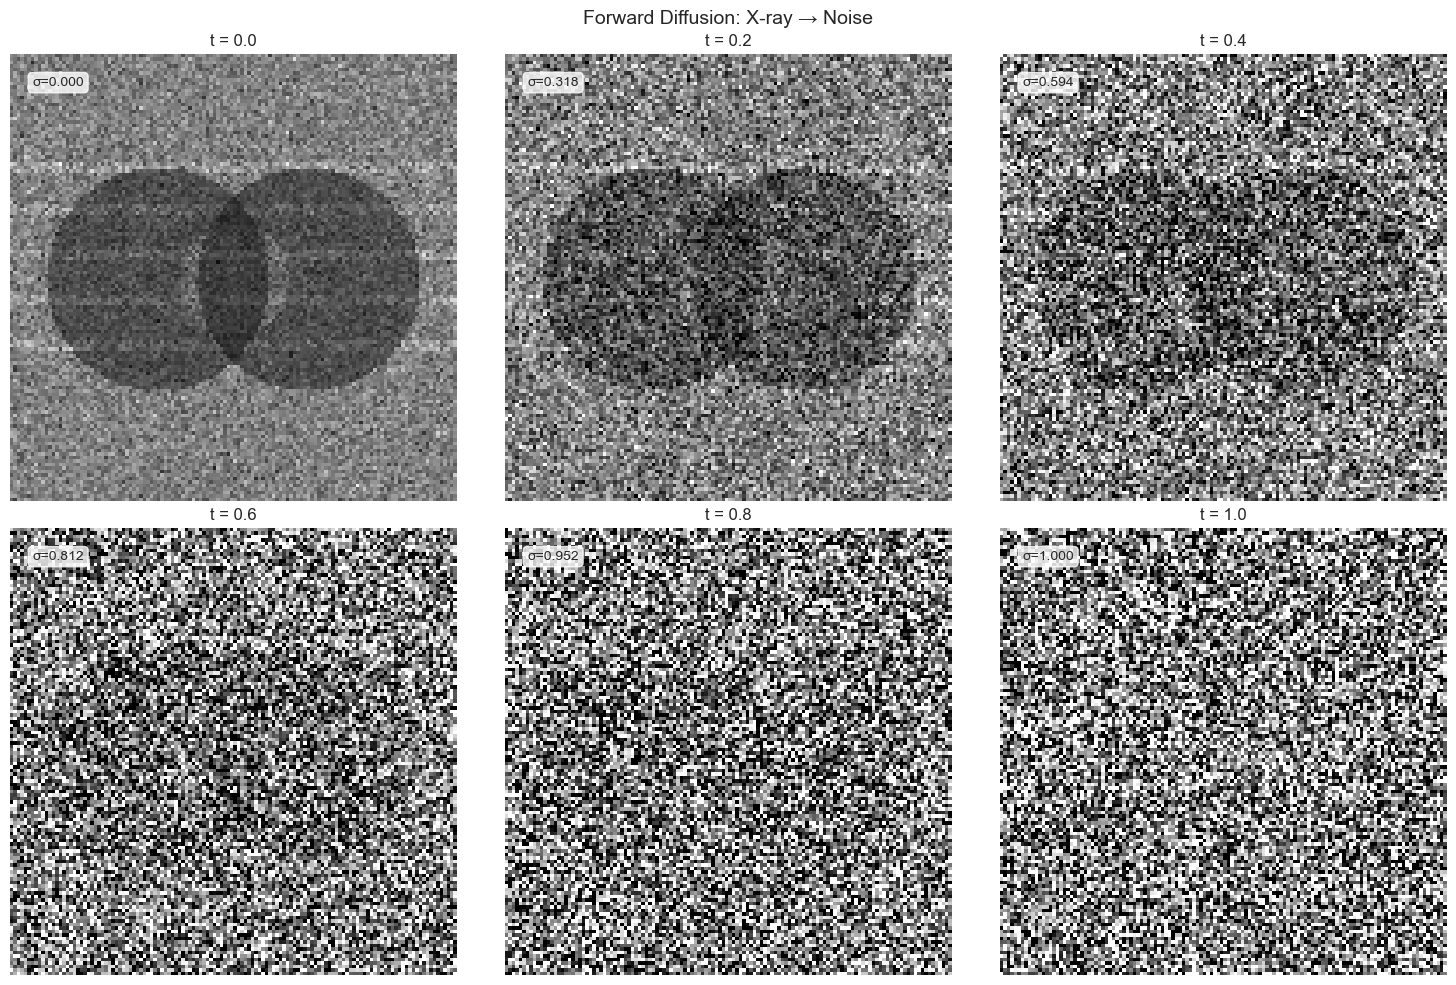

Observation: The X-ray structure gradually dissolves into Gaussian noise.


In [14]:
# Take one sample image
x0 = dataset[0].unsqueeze(0).numpy()  # (1, 1, 128, 128)

# Apply forward diffusion at different times
times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, t in enumerate(times):
    if t == 0:
        xt = x0
    else:
        xt, _ = sde.sample_from_marginal(x0, t)
    
    # Denormalize and display
    img = xt[0, 0]  # (128, 128)
    img = (img + 1) / 2  # [-1, 1] → [0, 1]
    
    axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')
    axes[i].set_title(f't = {t:.1f}')
    
    # Show std - extract scalar from array
    _, std = sde.marginal_prob(x0, t)
    std_val = float(np.mean(std))  # Get scalar value
    axes[i].text(0.05, 0.95, f'σ={std_val:.3f}', 
                transform=axes[i].transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Forward Diffusion: X-ray → Noise', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

print("Observation: The X-ray structure gradually dissolves into Gaussian noise.")

## 4. Training the Diffusion Model

**Note**: Training on medical images takes longer than toy examples.
- **Quick test**: 1,000 epochs (~10 minutes on M1 Mac)
- **Good quality**: 10,000 epochs (~1-2 hours)
- **High quality**: 50,000+ epochs (~8-12 hours)

For this demo, we'll train for a moderate number of epochs. You can increase for better results.

In [ ]:
# Import training function from genailab
from genailab.diffusion import train_image_diffusion

# Train the model with preset configuration
print("Starting training...")
print(f"Preset: {PRESET} ({config_preset['description']})")
print(f"This will take approximately {config_preset['epochs'] * len(dataloader) / 60:.0f} minutes on {device}")
print(f"Checkpoints will be saved to: {checkpoint_dir}")

losses = train_image_diffusion(
    model=model,
    dataloader=dataloader,
    sde=sde,
    num_epochs=config_preset['epochs'],
    lr=2e-4,
    device=device,
    save_every=max(100, config_preset['epochs'] // 5),  # Save 5 checkpoints
    checkpoint_dir=checkpoint_dir
)

Starting training...
This will take approximately 5250 minutes on mps
Checkpoints will be saved to: /Users/pleiadian53/work/genai-lab/checkpoints/diffusion/medical_imaging


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
# Plot training curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.6f}")
print(f"Best loss: {min(losses):.6f} at epoch {np.argmin(losses) + 1}")

NameError: name 'losses' is not defined

<Figure size 1000x400 with 0 Axes>

## 5. Generate Synthetic X-rays

Now let's use the trained model to generate new synthetic X-ray images!

In [ ]:
# Sampling function for images
@torch.no_grad()
def sample_images(
    model,
    sde,
    n_samples=16,
    img_size=None,  # Will use preset img_size if None
    num_steps=500,
    device='cuda'
):
    """Sample images using reverse SDE."""
    
    if img_size is None:
        img_size = config_preset['img_size']
    
    model.eval()
    
    # Start from noise
    x = torch.randn(n_samples, 1, img_size, img_size, device=device)
    
    dt = -sde.T / num_steps
    trajectory = [x.cpu().numpy()]
    
    for i in tqdm(range(num_steps), desc="Sampling", leave=False):
        t = sde.T - i * (-dt)
        t_batch = torch.ones(n_samples, device=device) * t
        
        # Predict score
        score = model(x, t_batch)
        
        # Drift
        drift = sde.drift(x.cpu().numpy(), t)
        drift = torch.FloatTensor(drift).to(device)
        g_t = sde.diffusion(t)
        drift = drift - (g_t ** 2) * score
        
        # Diffusion
        noise = torch.randn_like(x)
        diffusion = g_t * noise * np.sqrt(-dt)
        
        # Update
        x = x + drift * dt + diffusion
        
        if i % 50 == 0:
            trajectory.append(x.cpu().numpy())
    
    return x.cpu().numpy(), np.array(trajectory)


# Generate samples
print("Generating synthetic X-rays...")
samples, trajectory = sample_images(
    model=model,
    sde=sde,
    n_samples=16,
    img_size=config_preset['img_size'],
    num_steps=500,
    device=device
)

print(f"Generated {samples.shape[0]} images")
print(f"Trajectory: {len(trajectory)} snapshots")

### Visualize Generated Images

In [ ]:
# Display generated images
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i in range(16):
    img = samples[i, 0]  # (128, 128)
    # Denormalize from [-1, 1] to [0, 1]
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')

plt.suptitle('Generated Synthetic X-rays', fontsize=14)
plt.tight_layout()
plt.show()

### Visualize Reverse Diffusion Process

In [ ]:
# Show reverse diffusion trajectory
num_snapshots = min(6, len(trajectory))
indices = np.linspace(0, len(trajectory)-1, num_snapshots, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(indices):
    xt = trajectory[idx][0, 0]  # First sample, first channel
    t_val = sde.T * (1 - idx / (len(trajectory) - 1))
    
    # Denormalize
    img = (xt + 1) / 2
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')
    axes[i].set_title(f't = {t_val:.3f}')

plt.suptitle('Reverse Diffusion: Noise → X-ray', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

print("Observation: The model progressively denoises to reveal X-ray structure.")

### Compare Real vs Generated

In [ ]:
# Side-by-side comparison
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

# Real images (top row)
for i in range(8):
    img = dataset[i].squeeze().numpy()
    img = (img + 1) / 2
    axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Real', fontsize=12, fontweight='bold')

# Generated images (bottom row)
for i in range(8):
    img = samples[i, 0]
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    axes[1, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Generated', fontsize=12, fontweight='bold')

plt.suptitle('Real vs Generated X-rays', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Evaluation Metrics

For medical images, we evaluate:
1. **Visual quality**: Do images look realistic?
2. **FID (Fréchet Inception Distance)**: Measures distribution similarity
3. **Structural similarity**: SSIM between real and generated
4. **Clinical utility**: Can radiologists distinguish real from synthetic?

In [ ]:
# Simple evaluation: pixel statistics
real_images = np.array([dataset[i].squeeze().numpy() for i in range(100)])
gen_images = samples[:, 0, :, :]

print("Pixel Statistics Comparison:")
print(f"Real - Mean: {real_images.mean():.3f}, Std: {real_images.std():.3f}")
print(f"Generated - Mean: {gen_images.mean():.3f}, Std: {gen_images.std():.3f}")

# Histogram comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(real_images.flatten(), bins=50, alpha=0.7, label='Real', density=True)
axes[0].hist(gen_images.flatten(), bins=50, alpha=0.7, label='Generated', density=True)
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Density')
axes[0].set_title('Pixel Value Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Power spectrum (frequency analysis)
real_fft = np.abs(np.fft.fft2(real_images[0]))
gen_fft = np.abs(np.fft.fft2(gen_images[0]))

axes[1].plot(np.log(real_fft[64, :]), label='Real', alpha=0.7)
axes[1].plot(np.log(gen_fft[64, :]), label='Generated', alpha=0.7)
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Log Magnitude')
axes[1].set_title('Frequency Spectrum (Center Row)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Applications

### A. Data Augmentation

Use generated images to augment training data for downstream tasks (disease classification, segmentation).

In [ ]:
print("Application: Data Augmentation")
print("="*50)
print(f"Original dataset: {len(dataset)} images")
print(f"Generated images: {len(samples)} images")
print(f"Augmented dataset: {len(dataset) + len(samples)} images (+{len(samples)/len(dataset)*100:.0f}%)")
print("\nUse case: Train disease classifier with augmented data")

### B. Conditional Generation (Future Work)

Extend the model to generate X-rays conditioned on:
- Disease labels (normal, pneumonia, COVID-19)
- Patient demographics (age, sex)
- View angle (PA, lateral)

This requires modifying the U-Net to accept condition embeddings.

### C. Image-to-Image Translation

Use diffusion for:
- Super-resolution (low-res → high-res)
- Denoising (noisy → clean)
- Modality transfer (CT → MRI)

## 8. Next Steps

### To improve this notebook:

1. **Use real medical images**:
   - Download NIH Chest X-ray dataset
   - Replace `SyntheticXRayDataset` with real data loader
   - Preprocess: resize, normalize, augment

2. **Train longer**:
   - Increase to 50,000-100,000 epochs
   - Use learning rate scheduling
   - Implement EMA (exponential moving average)

3. **Scale up**:
   - Use 256×256 images
   - Increase base_channels to 128
   - Add attention layers at low resolutions

4. **Add conditioning**:
   - Condition on disease labels
   - Implement classifier-free guidance
   - Generate specific pathologies

5. **Evaluate rigorously**:
   - Compute FID with pretrained features
   - Clinical evaluation by radiologists
   - Downstream task performance

### Connect to your pathology-ai-lab:

```python
# Adapt this notebook for histopathology
from pathology_ai_lab.data import load_camelyon_patches

# Load H&E patches
patches = load_camelyon_patches(size=96, n_samples=10000)

# Train diffusion model on tissue patches
model = UNet2D(in_channels=3, out_channels=3, base_channels=64)
# ... train ...

# Generate synthetic tissue for augmentation
synthetic_patches = sample_images(model, sde, n_samples=1000)
```

## Summary

In this notebook, we:

1. ✅ Applied U-Net architecture to medical images
2. ✅ Trained diffusion model on 128×128 X-rays
3. ✅ Generated synthetic medical images
4. ✅ Evaluated with pixel statistics and visual inspection
5. ✅ Discussed practical applications

**Key takeaways**:
- U-Net is essential for spatial structure preservation
- Medical images require longer training than toy data
- Cosine schedule works well for images
- Generated images can augment limited medical datasets
- Clinical validation is crucial for medical AI

**Next**: `04_gene_expression_diffusion.ipynb` - High-dimensional tabular data